# Decision Trees

Decision trees are powerful models capable of fitting complex datasets. They are also the fundamental components of Random Forests.

## Training and Visualizing a Decision Tree

First, let's traing a `DecisionTreeClassifier` on the iris dataset:

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier


iris = load_iris()
X = iris.data[:, 2:]  # get petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2)

We can visualize the trained decision tree with the following code:

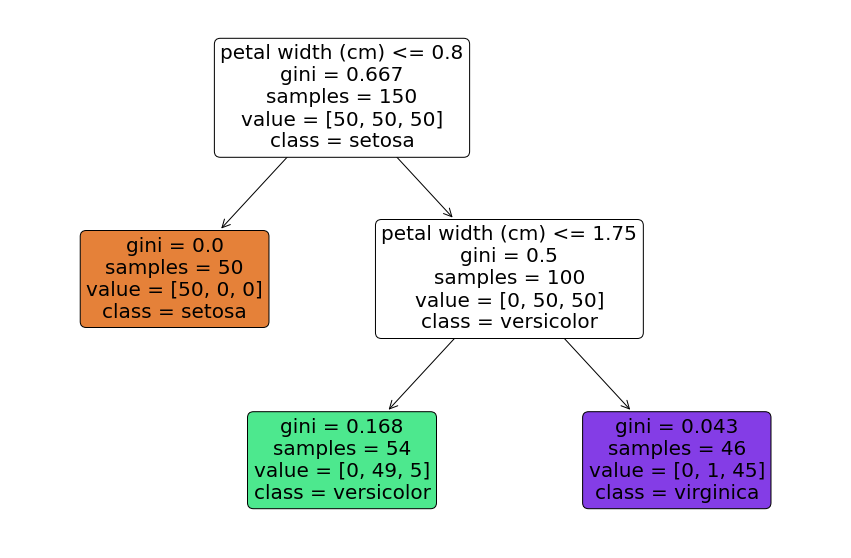

In [2]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt 

plt.figure(figsize=(15,10))  
plot_tree(tree_clf, feature_names=iris.feature_names[2:], class_names=iris.target_names, filled=True, fontsize=20, rounded=True)
plt.show()

## Making Predictions

To make predictions with a decision tree, you start at the root node (depth 0), and move down using the conditions in each node to determine which direction to go. You do this until you reach a *leaf node*. The leaf node does not ask any questions, you just look at the predicted class for that node. The leaf nodes are are the colored nodes shown above.

Notice that there was very little data preparation involved in training the decision tree. They do not require scaling or centering at all!

Each box in the figure above contains valuable information about the node. A node's `sample` attribute counts how many training instances it applies to. For example, 100 training instances have a petal width greater than 0.8 cm (depth 1, right), and of those 100, 54 have a petal width smaller than 1.75 cm (depth 2, left). A node's `value` attribute tells you how many training instances of each class this node applies to: for example, the bottom-right node applies to 0 *Iris setosa*, 1 *Iris versicolor*, and 45 *Iris virginica*. Finally, a node's `gini` attribute measures its *impurity*: a node is "pure" (`gini=0`) if all training instances it applies to belong to the same class. For example, since the depth-1 left node applies only to *Iris setosa* training instances, it is pure and its `gini` score is 0. The depth-2 left node has a `gini` score equal to $1-(0/54)^2-(49/54)^2-(5/54)^2\approx0.168$:

>Gini Impurity: $G_{i}=1-\sum^n_{k=1}p_{i, k}^2$

In this equation, $p_{i, k}$ is the ratio of class $k$ instances among the training instances in the $i^{\text{th}}$ node.

>Scikit-Learn uses the CART algorithm, which produces only *binary trees*: nonleaf nodes always have two children (i.e. questions can only have yes/no answers).

## Estimating Class Probabilities

A decision tree can estimate the probability that an instance belongs to a particular class $k$. First it traverses the tree to find the leaf node for this instance, and then it returns the ratio of training instances of class $k$ in this node. For example, suppose you have found a flower whose petals are 5 cm long and 1.5 cm wide. The corresponding leaf node is the depth-2 left node, so the Decision Tree should output the following probabilities: 0% for *Iris setosa* (0/54), 90.7% for *Iris versicolor* (49/54), and 9.3% for *Iris virginica* (5/54).

In [3]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [4]:
tree_clf.predict([[5, 1.5]])

array([1])

## The CART Training Algorithm

Scikit-Learn uses the *Classification and Regression Tree* (CART) algorithm to train Decision Trees (also called "growing trees"). The algorithm works by first splitting the training set into two subsets using a single feature $k$ and a threshold $t_k$. It searches for the pair $(k, t_k)$ that produces the purest subsets (weighted by their size):

> CART Cost Function for Classification: $J(k, t_k)=\frac{m_{\text{left}}}{m}G_{\text{left}}+\frac{m_{\text{right}}}{m}G_{\text{right}}$
where $G_{\text{left/right}}$ measures the impurity of the left/right subset, and $m_{\text{left/right}}$ is the number of instances in the left/right subset.

The CART algorithm splits the training set in two and continues on the subsets recursively. It stops once it reaches a maximum depth (defined by the `max_depth` hyperparameter), or if it cannot find a split that will reduce impurity. A few other hyperparameters control additional stopping conditions: `min_samples_split`, `min_samples_leaf`, `min_weight_fraction_leaf`, and `max_leaf_nodes`.

## Computational Complexity

Decision Trees are generally approximately balanced. Traversing the tree thus goes through roughly $O(\text{log}_{2}(m))$ nodes on average. Since each node only requires checking the value of one feature, the ovearl prediction complexity is $O(\text{log}_{2}(m))$, independent of the number of features. So predictions are very fast, even when dealing with large training sets.

The training algorithm compares all features (or less is `max_features` is set) on all samples at each node. Comparing all features on all samples at each node results in a training complexity of $O(n\times m \text{log}_{2}(m))$. For small training sets, we can speed up training by presorting the data (set `presort=True`), but this slows down training for larger training sets.

## Gini Impurity or Entropy

The Gini impurity measure is used by default, but you can select the *entropy* impurity measure instead by setting the `criterion` hyperparameter to '`entropy`'. Entropy is used as an impurity measure: a set's entropy is zero when it contains instances of only one class.

> Entropy: $H_i = - \sum_{k=1}^{n}p_{i, k}\text{log}_{2}(p_{i, k})$ where ${p_{i, k}\neq0}$

Gini impurity is slightly faster to compute, so it is a good default. When Entropy and Gini impurity are different to compute, the Gini impurity tends to isolate the most frequent class in its own branch of the tree, while entropy tends to produce slightly more balanced trees.

## Regularization Hyperparameters

Decision trees make very little assumptions avout the training data and are very prone to overfitting if they are left unconstrained. Such models are called *nonparametric*, i.e. the number of parameters is not determined prior to training so the model structure is free to stick closely to the data. On the other hand, a *parametric* model has a predetermined number of parameters, a limited degree of freedom, and a reduced risk of overfitting.

To avoid overfitting the training data, we restrict the decision tree's freedom during training by regularization. The most common hyperparameter we can restrict is the `max_depth`. This hyperparameter defines the maximum number of levels the resulting decision tree can have. The defaul value is `None`, which means *unlimited*.

There are a few other parameters that restrict the shape of a `DecisionTreeClassifier`: `min_samples_split` (the minimum number of samples a node must have before it can be split), `min_samples_leaf` (the minimum number of samples a leaf node must have), `min_weight_fraction_leaf` (same as `min_samples_leaf` but expressed as a fraction of the total number of weighted instances), `max_leaf_nodes` (the maximum number of leaf nodes, and `max_features` (the maximum number of features that are evaluated for splitting at each node).

Increasing `min_*` hyperparameters or reducing `max_*` hyperparameters will regularize the model.

## Regression

Decision trees are also capable of performing regression tasks. The difference is that instead of predicting a class in each node, it predicts a value. The value it predicts is the average target value of the training instances associated with a particular leaf node.

The figure below shows the predictions for a Decision tree fitted to a quadratic dataset with some noise added in. Notice that each 'level' on the red curve is roughly the average target value of the instances in that region. The algorithm splits each region in a way that makes most training instances as close as possible to that predicted value.

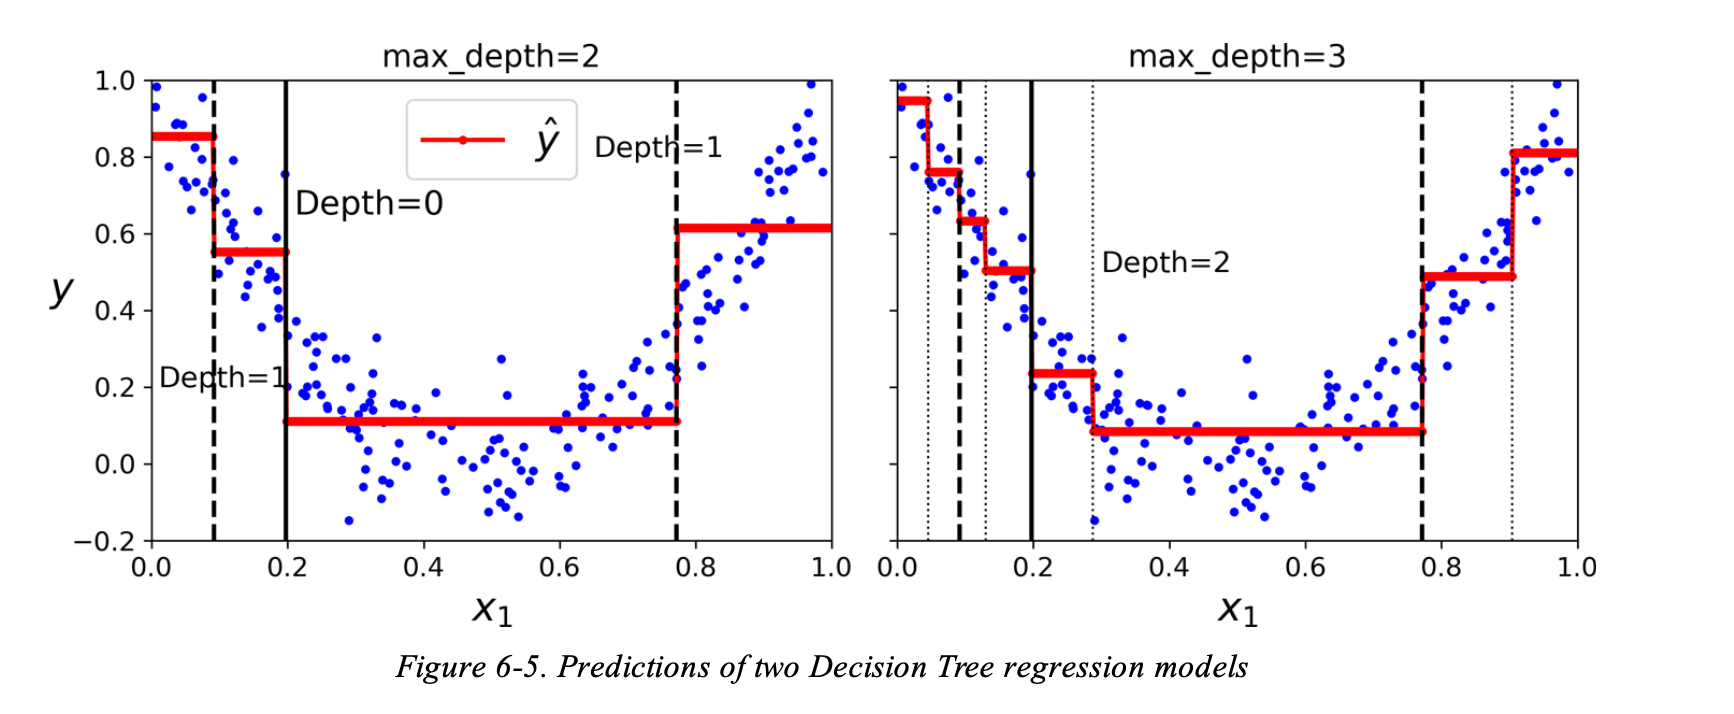

The CART algorithm works almost the same way as earlier, but instead of trying to split the training set in a way that minimizes impurity, it tries to split the training set in a way that minimizes the MSE:

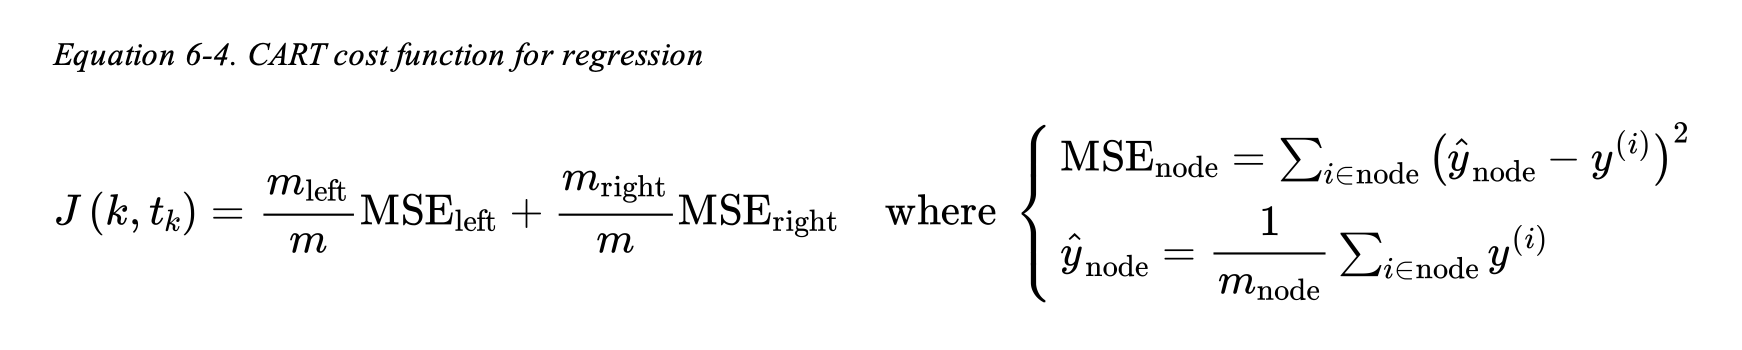

## Instability
 
Decision trees clearly have a lot going for them, but they certainly have limitations. One thing we can notice from the above figures is that decision trees love orthogonal decision boundaries (orthogonal to the $x$ and $y$ axes), which makes them sensitive to training set rotation. For example, below we can see a linearly separable training set. On the left, it is easily split with a vertical line. If we rotate the dataset by 45˚, the decision boundary is unnecessarily complicated. One way to limit this problem is to use Principal Component Analysis (PCA), which often results in the data having a better orientation.

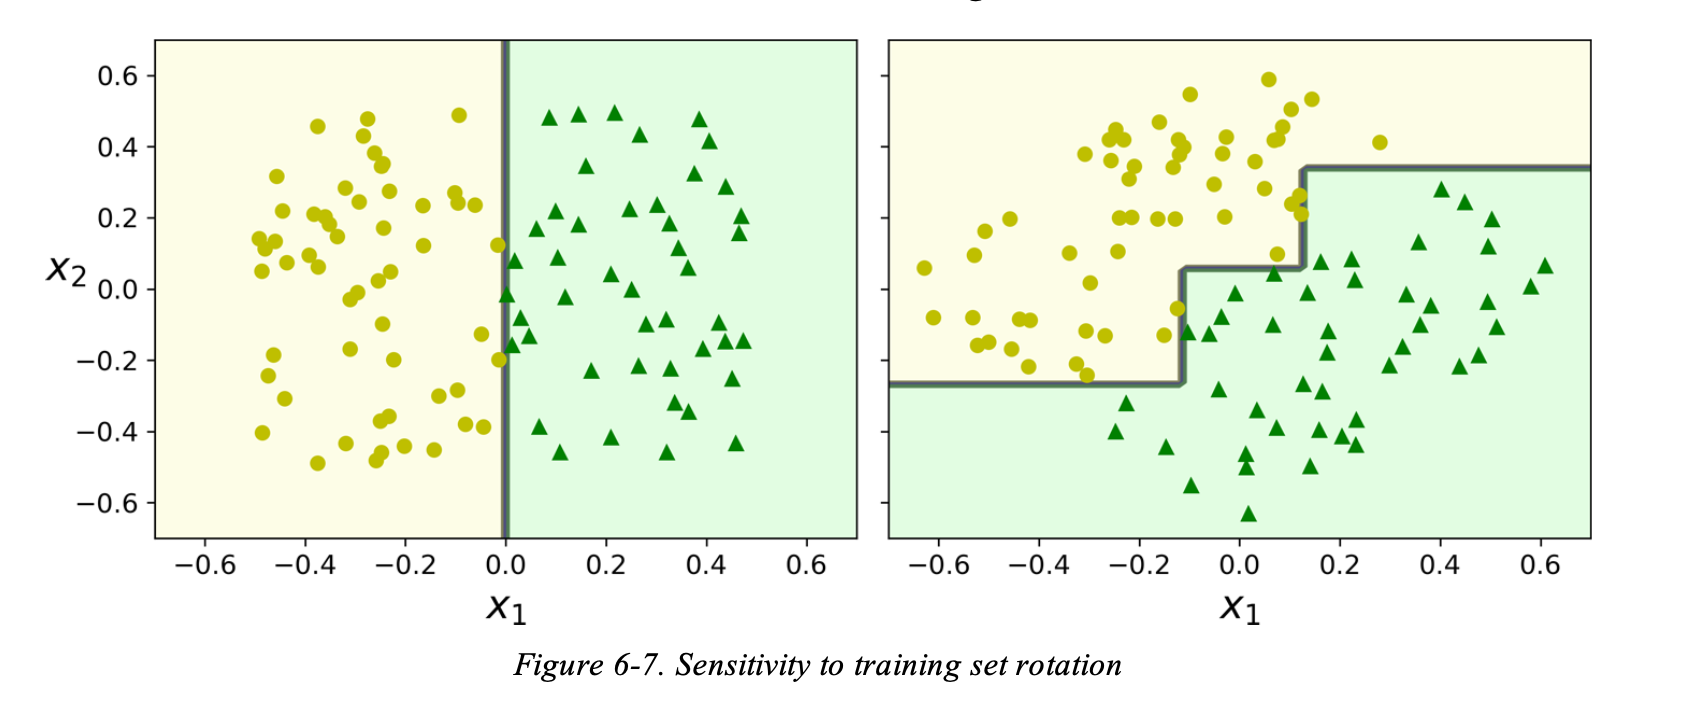

More generally, the issue with decision trees is that they have a pretty high variance. Random Forests can limit this instability by averaging predictions over many trees.

# Exercises

1. What is the approximate depth of a Decision Tree trained (without restrictions) on a training set with one million instances?
> The average depth of an unrestricted, but well balanced, decision tree is roughly $\log_{2}(m)$, where $m$ is the number of leaves. If each leaf corresponds to one instance, then we can expect the tree to have an approximate depth of $\log _{2}(10^{6})\approx20$.

2. Is a node's Gini impurity generally lower or greater than its parent's? Is it *generally* lower/greater, or *always* lower/greater?
> A node's Gini impurity is *generally* lower than its parent's. The CART algorithm is used to train decision trees in Scikit-Learn. It recursively splits the training set into two subsets with a cost function that is the weighted sum of the child node's Gini impurities. The parent node can be split in a way that causes a child node to have a higher impurity than the parent due to the weighted sum nature of the cost function. One child node may have an impurity that is higher than its parent if the second child node's impurity compensates for the loss of purity of the first child node. This scenario can result in a reduced cost function, even though one child node has a larger impurity than the parent.

3. If a Decision Tree is overfitting the training set, is it a good idea to try decreasing `max_depth`?
> If a decision tree is overfitting the training set, decreasing `max_depth` will decrease the number of levels in the final decision tree. This will prevent the tree from adapting itself to the training data too well, decreasing the risk of overfitting.

4. If a Decision Tree is underfitting the training set, is it a good idea to try scaling the input features?
> Decision Trees do not require feature scaling or centering becauase the cost function is based on the weighted sum of the Gini impurities of a node's children. Scaling the input features will not help underfitting. A better solution would be to increase the `max_depth` parameter.

5. If it takes one hour to train a Decision Tree on a training set containing 1 million instances, roughly how much time will it take to train another Decision Tree on a training set of 10 million instances?
> Decision Tree train with a complexity of $O(n\times m\log_{2}(m))$, where $m$ is the number of training instances and $n$ is the number of features. With the same $n$, the ratio of the time complexities with increased $m$ is roughly 12, meaning it will take about 12 times longer, i.e. 12 hours to train the second Decision Tree.

6. If your training set contains 100,000 instances, will setting `presort=True` speed up training?
> Presorting will only help speed up training on small datasets, i.e. a few thousand instances or less. Training a dataset of 100,000 instances is likely to get bogged down in the sorting stage and so setting `presort=True` will likely increase training time. Further, the `presort` hyperparameter has been deprected since sklean v0.22, so it's likely that the feature was not that useful.